**Final assignment**

Target is to assess the development of biking routes between 2013 and 2018 in Helsinki area. I will map the times how fast a fast biker can get to each university campus in Metropolitan area (new Metropolia campus in Myllypuro included to bring some variety). In the light of the results, I will ponder if bike is a viable transportation option for students compared to public transportation in terms of transportation time. I will also map the development of biking traffic amounts from same years and ponder about the relation of possible change in travel time and possible change in traffic amount.  

In [66]:

#import modules
import pandas as pd
import geopandas as gpd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import folium
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx


#initialise variables,define filepaths
#fps = ["/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5931308.txt",
#"/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5949389.txt",
#"/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5960104.txt",
#"/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5975376.txt",
#"/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5972102.txt",
#"/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/travel_times_to_ 5961860.txt"]

fps = ["data/travel_times_to_ 5949389_Kumpula.txt"]
cell_ID = fps[0].split("_")[-1][:-4]


In [ ]:
def FileFinder(YKR_ids):
    """
    Gets the data for certain cell of Helsinki Travel time matrix. Insert the id of the cell or list of ids if many.
    """
    
    for i in YKR_ids:
        
        folder = str(i[0:4])
        
        fp = data/folder/i

In [74]:
z = 45678909876
print(str(z)[0:4])

4567


In [56]:
#table joiner
def TableJoiner(filepaths):
    """
    Gets the YKR grid and merges the grid with accessibility data from chosen grid cells
    """
    i=0

    #fpgrid = "/Users/sonjakoivisto/Downloads/HelsinkiTravelTimeMatrix2018/data/MetropAccess_YKR_grid_EurefFIN.shp"
    fpgrid = "data/MetropAccess_YKR_grid_EurefFIN.shp"
    grid = gpd.read_file(fpgrid)

    #iterate over filepaths
    for fp in filepaths:

        #read in the file
        data = pd.read_csv(fp, sep=";", usecols=["from_id", "bike_f_t", "pt_r_t", "car_r_t"])
        #get the cell number and add it to all travel time columns to distinguish them
        cell_ID = fp.split("_")[-1][:-4]
        new_names = {"from_id": "YKR_ID", "pt_r_t": "pt_r_t_" + cell_ID, "bike_f_t": "bike_f_t_" + cell_ID,
        "car_r_t": "car_r_t_" + cell_ID}
        data= data.rename(columns=new_names)
    
        #merge file with grid on the id of cells and remove no data values
        grid = grid.merge(data, on="YKR_ID")
        grid.replace(to_replace=-1, value=np.nan, inplace=True)
        grid = grid.dropna()

        i+=1

    #grid = grid.set_index("YKR_ID")
    return grid
    
geodata = TableJoiner(fps)
geodata

,x,y,YKR_ID,geometry,bike_f_t_Kumpula,pt_r_t_Kumpula,car_r_t_Kumpula
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",79.0,127.0,56.0
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",78.0,130.0,56.0
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",78.0,132.0,56.0
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",80.0,136.0,56.0
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",77.0,120.0,55.0
...,...,...,...,...,...,...,...
13226,372875.0,6665630.0,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",71.0,84.0,65.0
13227,373125.0,6665630.0,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",71.0,86.0,65.0
13228,372375.0,6665380.0,6018252,"POLYGON ((372500.000 6665250.000, 372250.000 6...",73.0,87.0,66.0
13229,372625.0,6665380.0,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",72.0,89.0,66.0


'outputs/traveltimesKumpula.png'

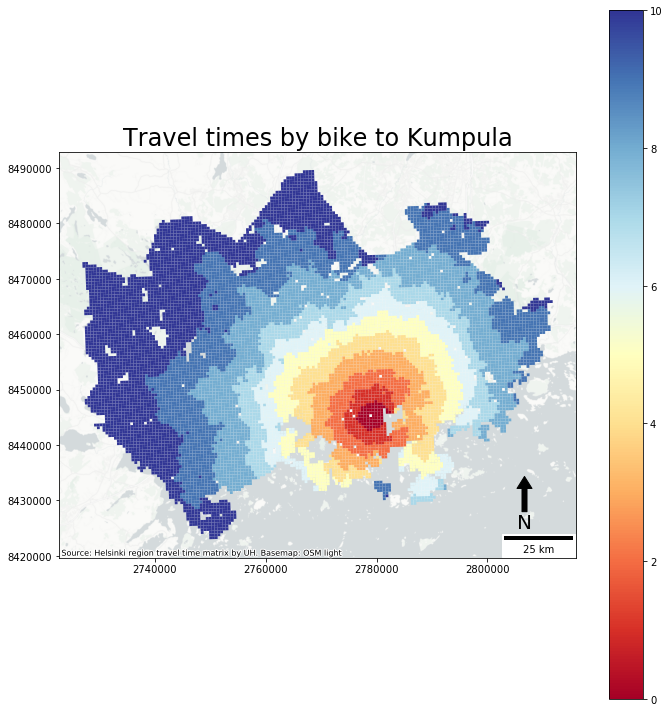

In [68]:
#visualiser
def visualiser(geodata, transport_method, interactive=None): 
    """
    Takes travel times to a grid cell and visualises them on a map. First argument is a geodataframe with the travel time values.
    Second argument is a transportation method (bike, public transport or car) which you want to visualise. The third agrument
    is optional and can be added to obtain interactive map as a result.
    """
    
    #make the column name which should be visualised according to user input
    if(transport_method == "bike"):
        column_name = "bike_f_t_" + cell_ID
        
    elif(transport_method == "public transport"):
        column_name = "pt_r_t_" + cell_ID
        
    elif(transport_method == "car"):
        column_name = "car_r_t_" + cell_ID
        
    else:
        print("Transport method should be one of the following: bike, public transport or car. Please insert a string")
            
    #change crs to add basemap later
    geodata = geodata.to_crs(epsg=3857)
    
    #define class breaks to array seen below (upper limits), apply this classification to pt and car travel times
    bins = [5,10,15,20,25,30,35,40,50,60]
    classifier = mapclassify.UserDefined(geodata[column_name], bins)
    
    #make new columns with class values
    geodata["classified"] = geodata[[column_name]].apply(classifier)
      
    #arrange the code somehow    
    if(type(transport_method)==list):
        transport1 = transport_method[0] + cell_ID
        transport2 = transport_method[1] + cell_ID
        geodata["difference"] = geodata[transport1] - geodata[transport2]
        

        classifier = mapclassify.UserDefined(geodata["difference"], bins)
        #make new columns with class values
        geodata["classified"] = geodata[["difference"]].apply(classifier)
        
    if(interactive == "yes"):
        
        m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=11, control_scale=True,
                       attribution = "Data: Helsinki Travel Time Matrix")

        folium.Choropleth(
        geo_data=geodata,
        name="Travel times" + cell_ID,
        data=geodata,
        columns=["YKR_ID", column_name],
        key_on="feature.id",
        bins = bins,
        fill_color="RdYlBu",
        fill_opacity=0.7,
        line_opacity=0.2,
        line_color="white",
        line_weight=0,
        highlight=True,
        legend_name="Travel times by " + transport_method,
        #tooltip=folium.Tooltip(fields=[column_name, "YKR_ID"], labels=True, sticky=True)
        ).add_to(m)
        
        
        folium.LayerControl().add_to(m)

        outfp= "data/traveltimes" + cell_ID + ".html"
        m.save(outfp)
        
        return m
    
    else:
        #plot
        fig, ax = plt.subplots(figsize=(10,10))

        #plot the travel times with fast bike
        geodata.plot(ax= ax, column="classified", cmap="RdYlBu", legend=True) 
        
        #add basemaps
        cartodb_url = "https://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png" 

        ctx.add_basemap(ax, attribution="Source: Helsinki region travel time matrix by UH. Basemap: OSM light", 
                url=cartodb_url)

        
        ax.set_title("Travel times by " + transport_method +" to "+ cell_ID, fontsize=24)
        plt.tight_layout()
        fig.show()
        
        #divider = make_axes_locatable(ax)
        #cax = divider.append_axes("right", size="5%", pad=0.05)
        #im = ax.imshow(ax)
        #im = ax.imshow(np.arange(100).reshape((10,10)))
        #plt.colorbar(ax, cax=cax)

        #add scalebar
        scalebar = ScaleBar(2.0, location=4) 
        plt.gca().add_artist(scalebar)
        
        #add north arrow
        x, y, arrow_length = 0.9, 0.2, 0.115
        ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
        
        #save and return fig
        output_fig = "outputs/traveltimes" + cell_ID + ".png"
        plt.savefig(output_fig)
        return output_fig


#visualiser(geodata, ["pt_r_t_", "bike_f_t_"])
visualiser(geodata, "bike")

In [ ]:
def comparer(geodata, transport_list):
    if(type(transport_method)==list):
        geodata["difference"] = transport_method[0] - transport_method[1] 
        classifier = mapclassify.UserDefined(geodata["difference"], bins)
        #make new columns with class values
        geodata["classified"] = geodata[["difference"]].apply(classifier)
        
        
        
    if(interactive == "yes"):
        
        m = folium.Map(location=[60.25, 24.8], tiles = 'cartodbpositron', zoom_start=11, control_scale=True,
                       attribution = "Data: Helsinki Travel Time Matrix")

        folium.Choropleth(
        geo_data=geodata,
        name="Travel times" + cell_ID,
        data=geodata,
        columns=["YKR_ID", column_name],
        key_on="feature.id",
        bins = bins,
        fill_color="RdYlBu",
        fill_opacity=0.7,
        line_opacity=0.2,
        line_color="white",
        line_weight=0,
        highlight=True,
        legend_name="Travel times by " + transport_method,
        tooltip=folium.Tooltip(fields=[column_name, "YKR_ID"], 
        labels=True, sticky=True)).add_to(m)
        
        
        folium.LayerControl().add_to(m)

        outfp= "data/traveltimes" + cell_ID + ".html"
        m.save(outfp)
        
        return m